In [2]:
import chardet
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
import time
import seaborn as sns
import string
import pandas as pd
import matplotlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud

In [3]:
with open('../data/sms_spam.txt', 'rb') as f:
    result = chardet.detect(f.read())
sms_mes = pd.read_csv('../data/sms_spam.txt', names=['label', 'message'], encoding=result['encoding'], sep = '\t')
sms_mes['label'] = sms_mes.label.map({'ham': 0, 'spam': 1})

In [4]:
def preprocess_text(text):
    # remove special chars
    text = re.sub('[^a-zA-Z0-9]+', ' ', text.lower())
    # remove stopwords
    stops = set(stopwords.words("english"))
    text = [word for word in text.split() if not word in stops]

    # stem words
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text]
    
    return " ".join(text)

sms_mes['message'] = sms_mes['message'].apply(preprocess_text)

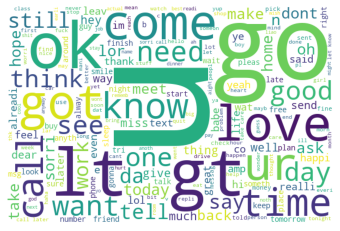

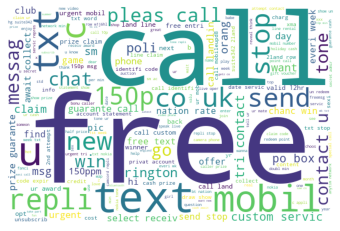

In [5]:
def visualize(label_index, label_name):
    text = ''
    for msg in sms_mes[sms_mes['label'] == label_index]['message']:
        msg = msg.lower()
        text += msg + ' '
    wordcloud = WordCloud(width=600, height=400, background_color="white").generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

visualize(0, 'ham')
visualize(1, 'spam')

In [6]:
# Split Dataset on labels and features
x = sms_mes['message']
y = sms_mes['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [7]:
'''
vectorizer = TfidfVectorizer()
cv_x_train = vectorizer.fit_transform(x_train)
cv_x_test = vectorizer.transform(x_test)
'''
# CV more effective
vectorizer = CountVectorizer()
cv_x_train = vectorizer.fit_transform(x_train)
cv_x_test = vectorizer.transform(x_test)


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1219
           1       0.95      0.95      0.95       174

    accuracy                           0.99      1393
   macro avg       0.97      0.97      0.97      1393
weighted avg       0.99      0.99      0.99      1393

Accuracy:  0.9870782483847811


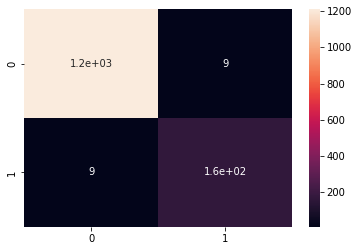

In [8]:
'''
rfc = RandomForestClassifier()
rfc.fit(cv_x_train, y_train)
y_pred = rfc.predict(cv_x_test)

'''
# NB more effective
nB = MultinomialNB()
nB.fit(cv_x_train, y_train)
y_pred = nB.predict(cv_x_test)


print(classification_report(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True)
plt.show()

In [14]:
def plot_top_words(model, topics_count, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, topics_count, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

c:\users\alexe\pycharmprojects\data-analysis\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


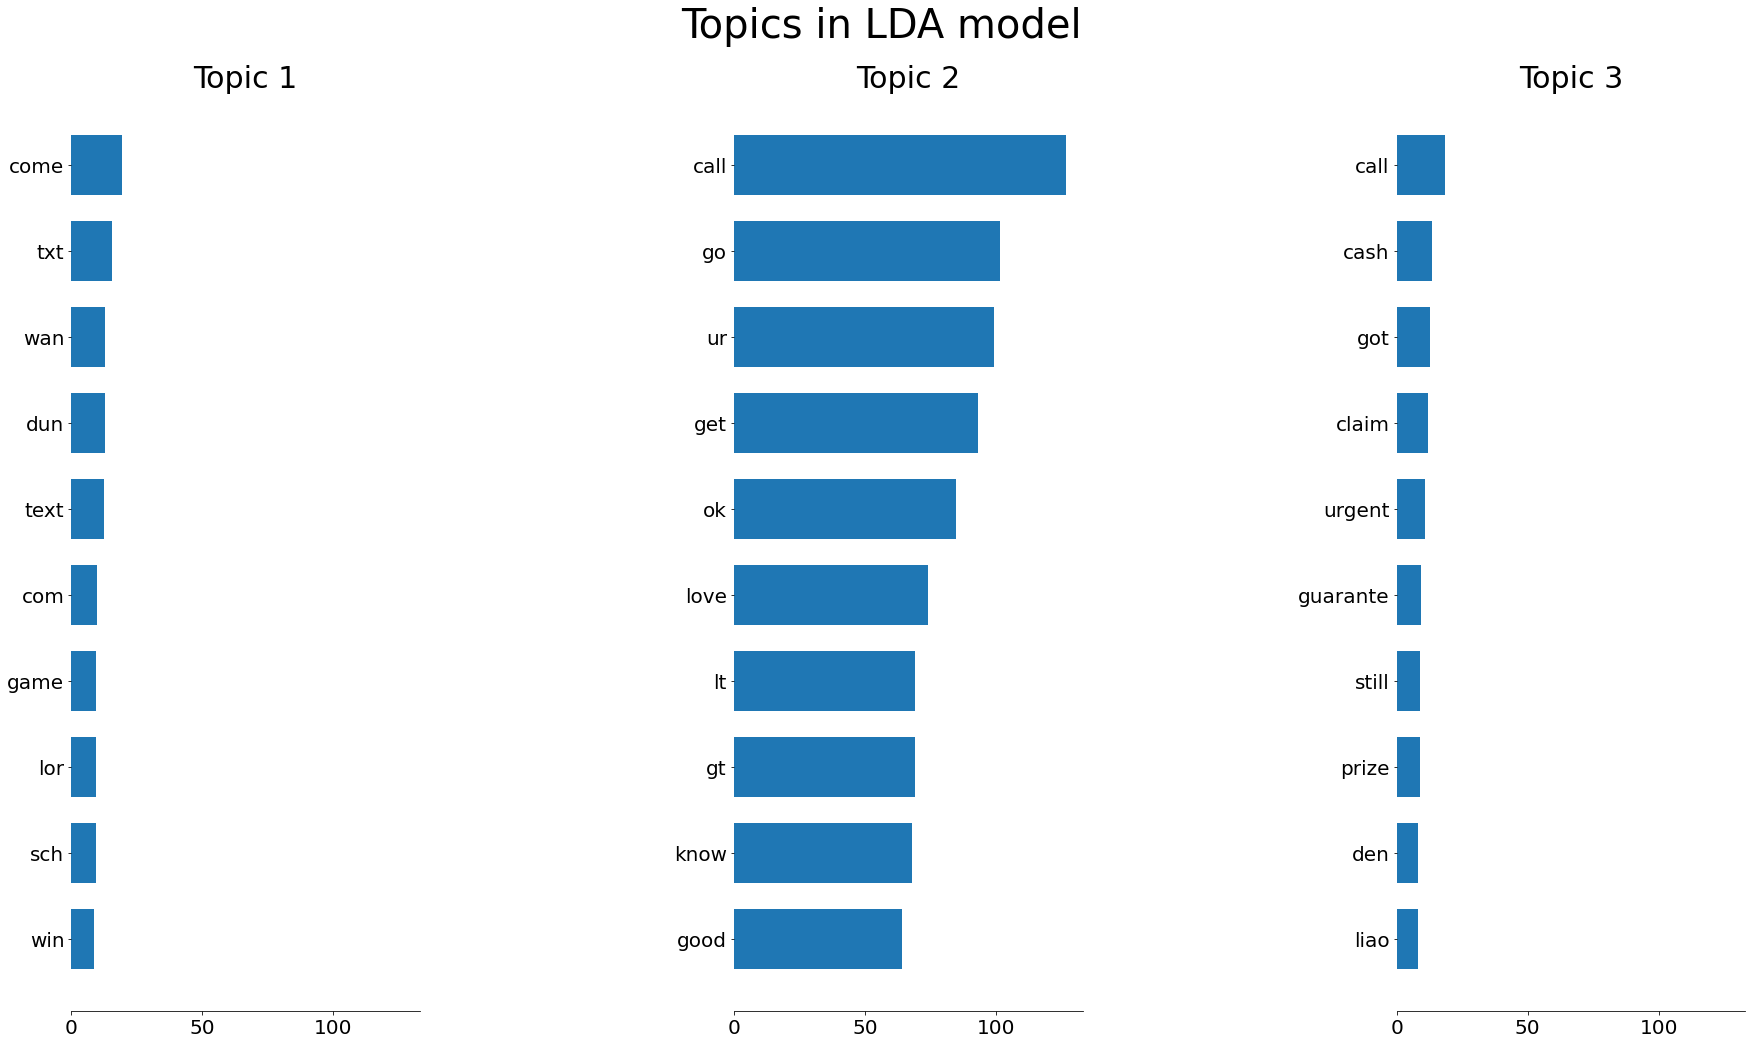

In [15]:
n_components = 3
n_top_words = 10
lda = LatentDirichletAllocation(n_components=n_components, max_iter=7,
                                learning_method='online',
                                learning_offset=50.)

lda.fit(cv_x_train)
lda.fit(cv_x_test)
feature_names = vectorizer.get_feature_names()
plot_top_words(lda, n_components, feature_names, n_top_words, 'Topics in LDA model')